<h1>DISASTER TWEETS ANALYZER ENHANCED BY NLP AND LLM</h1>

<h1>Dataset Overview</h1>
The training set includes 7,613 tweets, each identified by a unique `id`. Each tweet may have a `keyword`, `location`, and `text`, with an additional binary indicator showing whether the tweet signifies a real disaster. In contrast, the test set comprises 3,263 tweets with the same features but lacks the `target` variable, which needs to be predicted. Below is a description of the dataset features:
<h3>id:</h3>  A unique identifier for each tweet.
<h3>keyword:</h3> A significant term extracted from the tweet.
<h3>location:</h3> The geographic origin of the tweet.
<h3>text:</h3> The content of the tweet.
<h3>target:</h3> A binary variable where 0 indicates the absence of a real disaster and 1 indicates the presence of a real disaster.


In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import string
from sklearn.feature_extraction.text import CountVectorizer


# load the data

data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
submission_data = pd.read_csv('sample_submission.csv')

In [6]:
# Summary of the training dataset

print(f'The training dataset includes {len(data_train)} tweets.')
data_train[['id', 'text', 'target']]
# Display the first few rows of the datasets
data_train.head()

The training dataset includes 7613 tweets.


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Information about the test sets

print(f'The test dataset includes {len(data_test)} tweets.')
data_test_target = data_test.copy()
data_test_target['target'] = '?'
data_test_target[['id', 'text', 'target']]
# Display the first few rows of the datasets
data_test_target.head()

The test dataset includes 3263 tweets.


,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,?
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",?
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",?
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,?
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,?


In [8]:
print(submission_data.head())

   id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0


<h1>Exploratory Data Analysis (EDA)</h1>
To analyze and compare the two categories of tweets non-disaster and disaster. We partition the training data according to the target feature.






In [9]:
# Basic information about the data

print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [10]:
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In [11]:
print(submission_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB
None


In [12]:
# Number of unique values in keyword and location
print(f'Unique keywords in training set: {data_train["keyword"].nunique()} - In test set: {data_test["keyword"].nunique()}')
print(f'Unique locations in training set: {data_train["location"].nunique()} - In test set: {data_test["location"].nunique()}')

Unique keywords in training set: 221 - In test set: 221
Unique locations in training set: 3341 - In test set: 1602


In [13]:
# Checking for missing values

print(data_train[['keyword', 'location']].isnull().sum())
print(data_test[['keyword', 'location']].isnull().sum())

keyword       61
location    2533
dtype: int64
keyword       26
location    1105
dtype: int64


In [14]:
# Summary statistics of numerical columns

print(data_train.describe())

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


In [15]:
print(submission_data.describe())

                 id  target
count   3263.000000  3263.0
mean    5427.152927     0.0
std     3146.427221     0.0
min        0.000000     0.0
25%     2683.000000     0.0
50%     5500.000000     0.0
75%     8176.000000     0.0
max    10875.000000     0.0


In [16]:
# Split the training data based on the target variable

data_train_0 = data_train[data_train["target"] == 0]
data_train_1 = data_train[data_train["target"] == 1]

# Print the number of tweets for each class

print(f"Number of training tweets not indicating real disasters: {len(data_train_0)}")
print(f"Number of training tweets indicating real disasters: {len(data_train_1)}")

Number of training tweets not indicating real disasters: 4342
Number of training tweets indicating real disasters: 3271


# Class

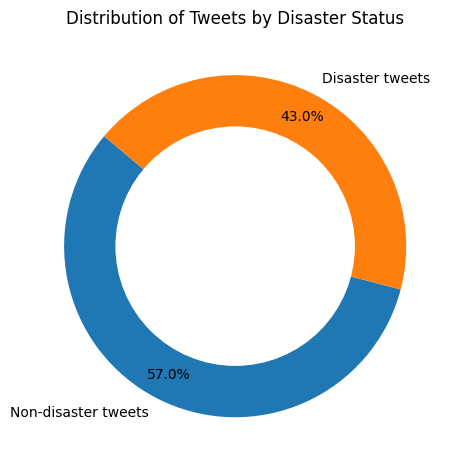

In [17]:
# Visualization Function
def donut_plot(value, label, color, title):
    fig, ax = plt.subplots()
    ax.pie(value, labels=label, colors=color, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Visualization of class frequencies

target_counts = np.array([len(data_train_0), len(data_train_1)])
donut_plot(
    value=target_counts,
    label=["Non-disaster tweets", "Disaster tweets"],
    color=["#1f77b4", "#ff7f0e"],
    title="Distribution of Tweets by Disaster Status"
)

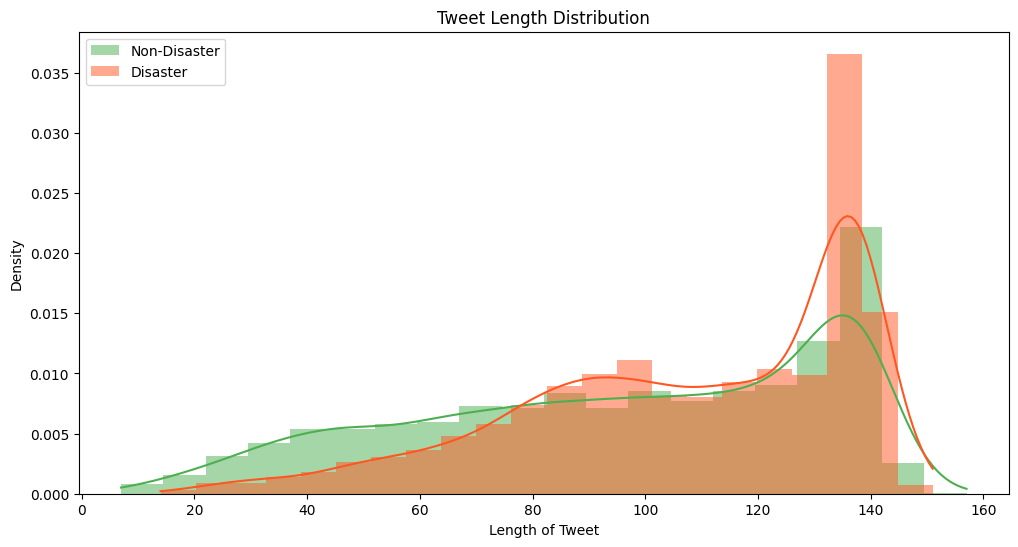

In [18]:
# Compute tweet lengths
data_train['text_length'] = data_train['text'].apply(len)
data_test['text_length'] = data_test['text'].apply(len)

# Plot tweet length distribution
plt.figure(figsize=(12, 6))

# Plot for non-disaster tweets
sns.histplot(data_train[data_train['target'] == 0]['text_length'], color='#4CAF50', label='Non-Disaster', kde=True, stat='density', linewidth=0)

# Plot for disaster tweets
sns.histplot(data_train[data_train['target'] == 1]['text_length'], color='#FF5722', label='Disaster', kde=True, stat='density', linewidth=0)

plt.title('Tweet Length Distribution')
plt.xlabel('Length of Tweet')
plt.ylabel('Density')
plt.legend()
plt.show()

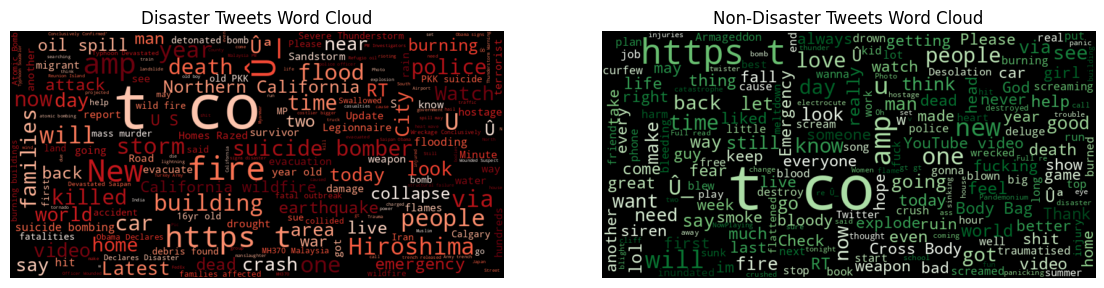

In [19]:
# Wordcloud for disaster and non-disaster tweets

from wordcloud import WordCloud
from wordcloud import STOPWORDS

# Combine text from disaster and non-disaster tweets
disaster_text = ' '.join(data_train[data_train['target'] == 1]['text'])
non_disaster_text = ' '.join(data_train[data_train['target'] == 0]['text'])

# Generate word clouds with stop words removed
stopwords = set(STOPWORDS)
wordcloud_disaster = WordCloud(width=800, height=400, background_color='black', colormap='Reds', max_font_size=100).generate(disaster_text)
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='black', colormap='Greens', max_font_size=100).generate(non_disaster_text)

# Plot word clouds
plt.figure(figsize=(14, 7))

# Word cloud for disaster tweets
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Disaster Tweets Word Cloud')
plt.axis('off')

# Word cloud for non-disaster tweets
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Non-Disaster Tweets Word Cloud')
plt.axis('off')

plt.show()

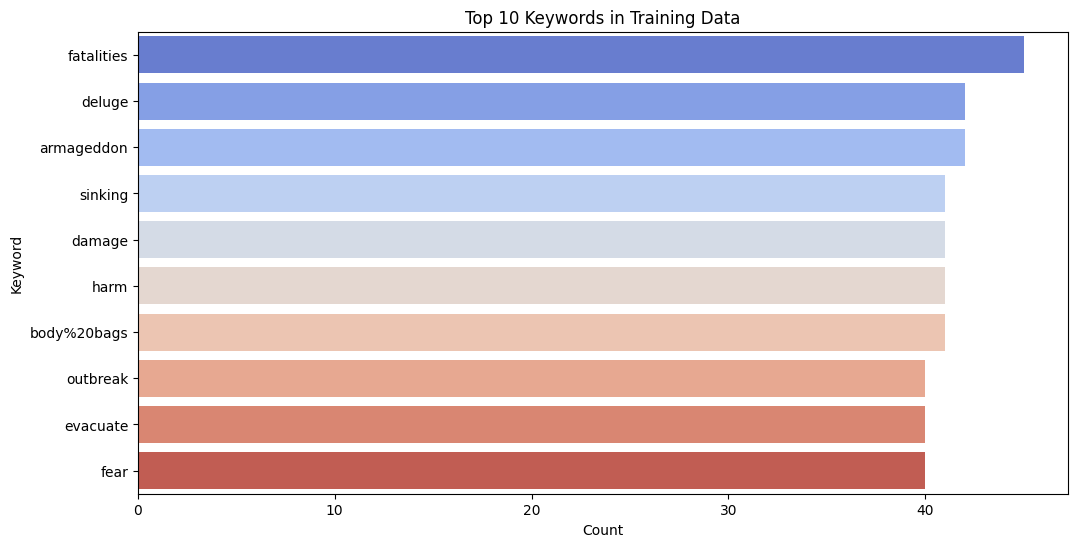

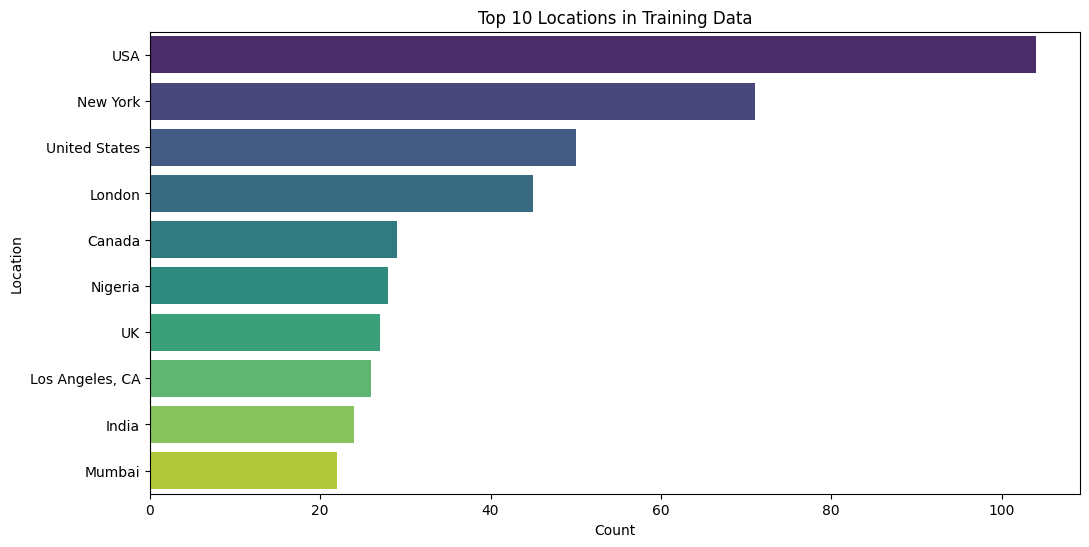

In [20]:
import warnings
warnings.filterwarnings('ignore')

# Visualizing Categorical Features
# Assuming there are some categorical features like 'keyword' and 'location'

# keyword
plt.figure(figsize=(12, 6))
ax = sns.countplot(y='keyword', data=data_train, order=data_train['keyword'].value_counts().iloc[:10].index,palette='coolwarm')
plt.title('Top 10 Keywords in Training Data')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

#location
plt.figure(figsize=(12, 6))
ax = sns.countplot(y='location', data=data_train, order=data_train['location'].value_counts().iloc[:10].index,palette='viridis')
plt.title('Top 10 Locations in Training Data')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

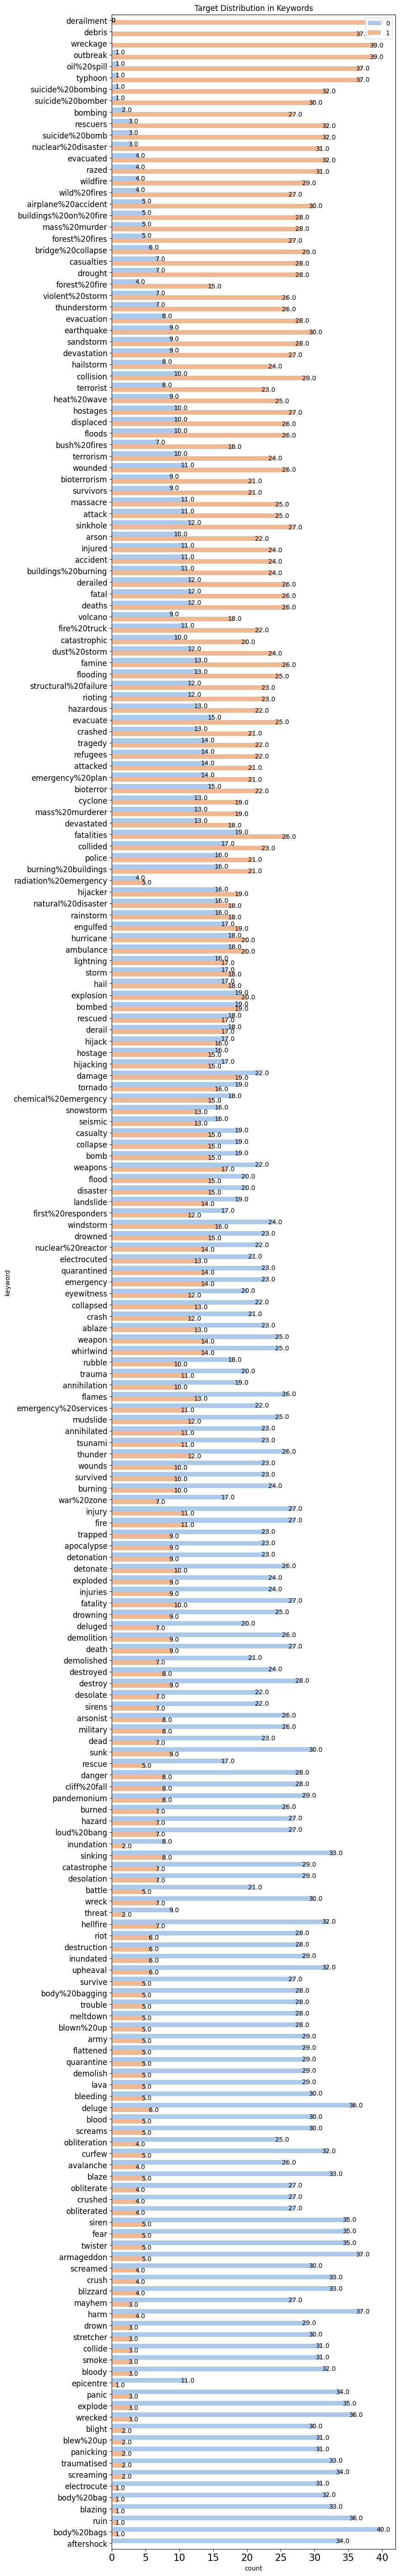

In [21]:
# Target distribution in keywords
data_train['target_mean'] = data_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)
sns.countplot(y=data_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=data_train.sort_values(by='target_mean', ascending=False)['target'],palette='pastel')

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

# Add annotations
for p in plt.gca().patches:
    width = p.get_width()
    plt.text(width + 0.2, p.get_y() + p.get_height() / 2, f'{width}',
             ha='center', va='center', fontsize=10)

plt.show()
data_train.drop(columns=['target_mean'], inplace=True)

<h1>Keyword</h1>
We visualize the proportion of NaN values for the keyword feature, as well as the top keywords (both as per total count and count per tweet) for each class.

In [22]:
# Keyword - main dataframe

def word_counter(word, text_list):
    """Counts the occurrences of a word in a list of text."""
    return text_list.str.lower().str.contains(word.lower()).sum()

# Convert keyword column to string and get unique keywords
keyword = data_train["keyword"].astype(str)
keyword_counts = keyword.value_counts()
keyword_unique = keyword_counts.index.tolist()
keyword_unique_count = [keyword_counts.get(word, 0) for word in keyword_unique]

# Compute counts for disaster and non-disaster tweets
keyword_0 = data_train_0["keyword"].astype(str)
keyword_1 = data_train_1["keyword"].astype(str)

keyword_0_counts = keyword_0.value_counts()
keyword_1_counts = keyword_1.value_counts()

keyword_0_unique_count = [keyword_0_counts.get(word, 0) for word in keyword_unique]
keyword_1_unique_count = [keyword_1_counts.get(word, 0) for word in keyword_unique]

# Create DataFrame
keyword_df = pd.DataFrame()
keyword_df["keyword"] = keyword_unique
keyword_df["count (all tweets)"] = keyword_unique_count
keyword_df["proportion (all tweets)"] = [count/len(keyword) for count in keyword_unique_count]
keyword_df["count (non-disaster tweets)"] = keyword_0_unique_count
keyword_df["proportion (non-disaster tweets)"] = [count/len(keyword_0) for count in keyword_0_unique_count]
keyword_df["count (disaster tweets)"] = keyword_1_unique_count
keyword_df["proportion (disaster tweets)"] = [count/len(keyword_1) for count in keyword_1_unique_count]
keyword_df["absolute difference"] = abs(keyword_df["proportion (disaster tweets)"] - keyword_df["proportion (non-disaster tweets)"])

# DataFrame for display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

# Display DataFrame
print(keyword_df.head())


      keyword  count (all tweets)  proportion (all tweets)  count (non-disaster tweets)  proportion (non-disaster tweets)  count (disaster tweets)  proportion (disaster tweets)  absolute difference
0         nan                  61                 0.008013                           19                          0.004376                       42                      0.012840             0.008464
1  fatalities                  45                 0.005911                           19                          0.004376                       26                      0.007949             0.003573
2      deluge                  42                 0.005517                           36                          0.008291                        6                      0.001834             0.006457
3  armageddon                  42                 0.005517                           37                          0.008521                        5                      0.001529             0.006993
4     sink

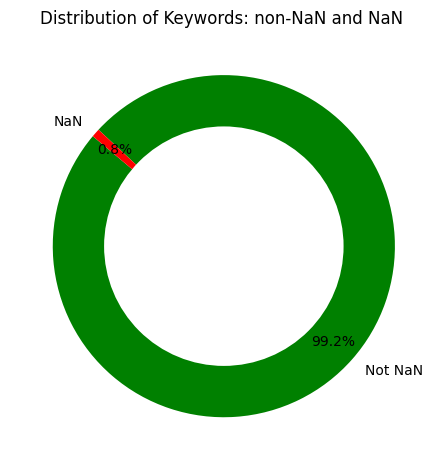

In [23]:
# Convert NaN values to string 'NaN' explicitly
keyword = data_train["keyword"].fillna('NaN')

nan_keyword_count = keyword[keyword == 'NaN'].count()
non_nan_keyword_count = len(keyword) - nan_keyword_count

keyword_frequency = np.array([non_nan_keyword_count, nan_keyword_count])
keyword_label = ["Not NaN", "NaN"]
keyword_color = ["green", "red"]

donut_plot(value=keyword_frequency, label=keyword_label, color=keyword_color, title="Distribution of Keywords: non-NaN and NaN ")

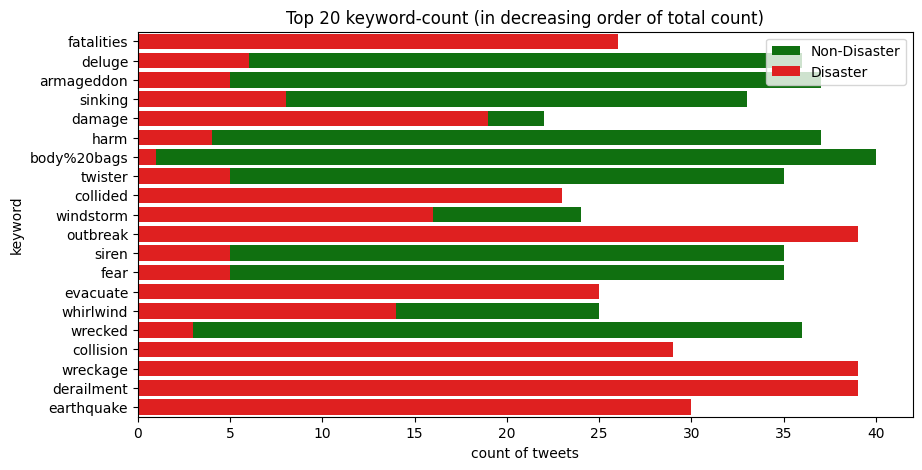

In [24]:
# Classwise keyword-count
keyword_df_count = keyword_df[["keyword", "count (all tweets)", "count (non-disaster tweets)", "count (disaster tweets)"]].sort_values(by = ["count (all tweets)"], ascending = False)

# deleting the rows with keyword NaN
keyword_df_count.drop(0, axis = 0, inplace = True)

def classwise_comparison_barplot(df, n, feature, non_disaster, disaster, xlabel, ylabel, title):

# Plots a barplot comparing the count of a feature for disaster and non-disaster tweets.

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(y=df[feature].values[:n], x=df[non_disaster].values[:n], ax=ax, color='green', label='Non-Disaster')
    sns.barplot(y=df[feature].values[:n], x=df[disaster].values[:n], ax=ax, color='red', label='Disaster')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Define the number of top keywords to display
N = 20

# Visualizing classwise comparison of keywords
classwise_comparison_barplot(df = keyword_df_count,
                             n = N,
                             feature = "keyword",
                             non_disaster = "count (non-disaster tweets)",
                             disaster = "count (disaster tweets)",
                             xlabel = "count of tweets",
                             ylabel = "keyword",
                             title = "Top 20 keyword-count (in decreasing order of total count)"
                            )


# Location

We visualize the proportion of NaN values for the location feature, as well as the top keywords (both as per total count and count per tweet) for each class.






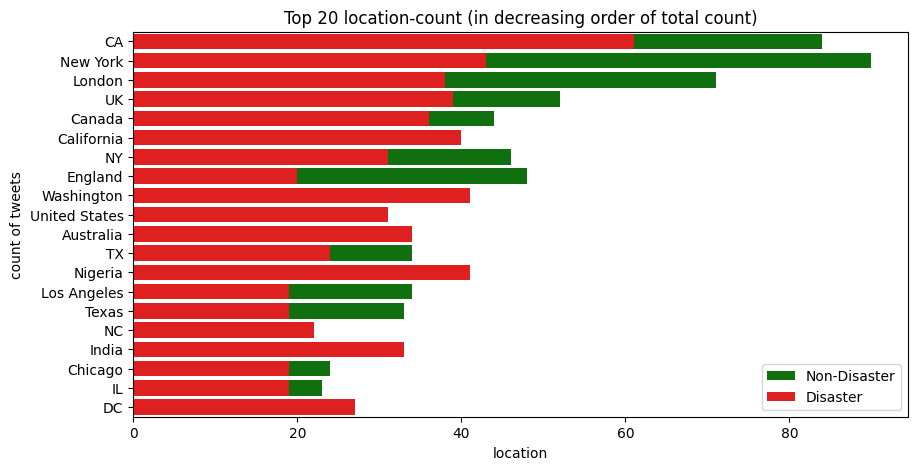

In [27]:
# Location
location = data_train["location"].fillna('NaN')
location_unique = set(location)
location_unique_count = [word_counter(word, location) for word in location_unique]

location_0 = data_train_0["location"].fillna('NaN')
location_0_unique_count = [word_counter(word, location_0) for word in location_unique]

location_1 = data_train_1["location"].fillna('NaN')
location_1_unique_count = [word_counter(word, location_1) for word in location_unique]

location_df = pd.DataFrame()
location_df["location"] = list(location_unique)
location_df["count (all tweets)"] = location_unique_count
location_df["proportion (all tweets)"] = [count/len(location) for count in location_unique_count]
location_df["count (non-disaster tweets)"] = location_0_unique_count
location_df["proportion (non-disaster tweets)"] = [count/len(location_0) for count in location_0_unique_count]
location_df["count (disaster tweets)"] = location_1_unique_count
location_df["proportion (disaster tweets)"] = [count/len(location_1) for count in location_1_unique_count]

# Classwise location-count
location_df_count = location_df[["location", "count (all tweets)", "count (non-disaster tweets)", "count (disaster tweets)"]].sort_values(by = ["count (all tweets)"], ascending = False)

# Drop NaN rows
drop_nan_rows(location_df_count, "location")

location_df_count.drop(0, axis = 0, inplace = True)  # deleting the rows with location NaN

classwise_comparison_barplot(df = location_df_count,
                              n = 20,
                              feature = "location",
                              non_disaster = "count (non-disaster tweets)",
                              disaster = "count (disaster tweets)",
                              xlabel = "location",
                              ylabel = "count of tweets",
                              title = "Top 20 location-count (in decreasing order of total count)"
                              )

# Meta Features

Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. Non-disaster tweets have more typos than disaster tweets because they are coming from individual users. The meta features used for the analysis are;



*  word_count number of words in text
*  unique_word_count number of unique words in text
*  stop_word_count number of stop words in text
*  url_count number of urls in text
*  mean_word_length average character count in words
*  char_count number of characters in text
*  punctuation_count number of punctuations in text
*  hashtag_count number of hashtags (#) in text
*  mention_count number of mentions (@) in text



In [28]:
# Feature Engineering
STOPWORDS = set([
    'a', 'an', 'the', 'and', 'or', 'but', 'in', 'on', 'at', 'with', 'by', 'for', 'of', 'to', 'from'
])

# word_count
data_train['word_count'] = data_train['text'].apply(lambda x: len(str(x).split()))
data_test['word_count'] = data_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
data_train['unique_word_count'] = data_train['text'].apply(lambda x: len(set(str(x).split())))
data_test['unique_word_count'] = data_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
data_train['stop_word_count'] = data_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
data_test['stop_word_count'] = data_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
data_train['url_count'] = data_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
data_test['url_count'] = data_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
data_train['mean_word_length'] = data_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
data_test['mean_word_length'] = data_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
data_train['char_count'] = data_train['text'].apply(lambda x: len(str(x)))
data_test['char_count'] = data_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
data_train['punctuation_count'] = data_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
data_test['punctuation_count'] = data_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
data_train['hashtag_count'] = data_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
data_test['hashtag_count'] = data_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
data_train['mention_count'] = data_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
data_test['mention_count'] = data_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))


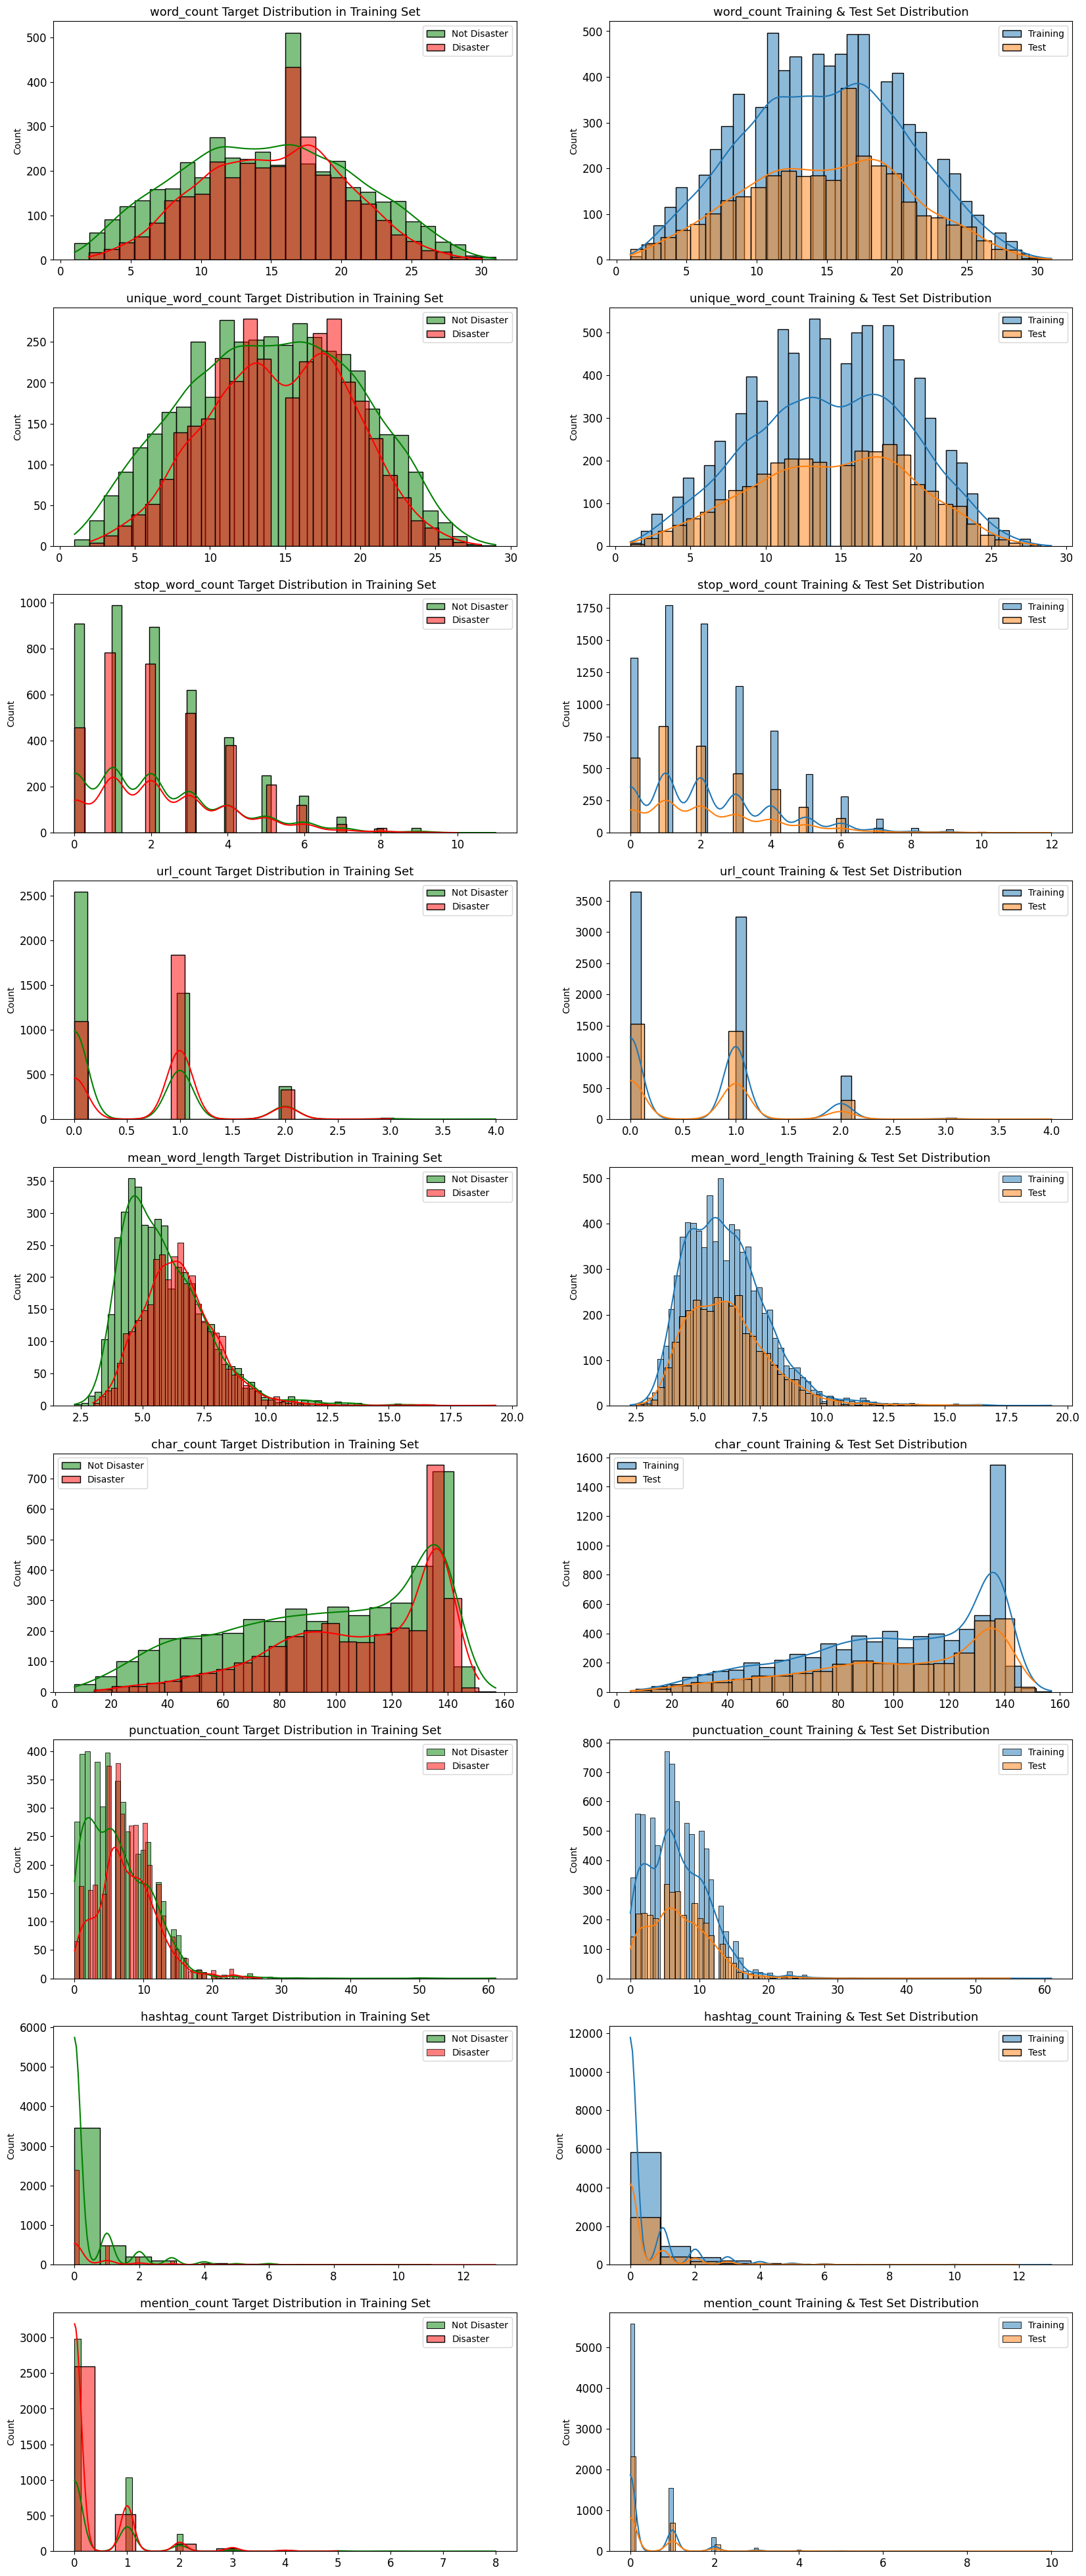

In [29]:
# Meta Features Distribution Visualization
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = data_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(data_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green', kde=True)
    sns.histplot(data_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red', kde=True)

    sns.histplot(data_train[feature], label='Training', ax=axes[i][1], kde=True)
    sns.histplot(data_test[feature], label='Test', ax=axes[i][1], kde=True)

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

# Number of Characters

We examine the distribution of number of characters per tweet for both the class of non-disaster tweets and the class of disaster tweets.

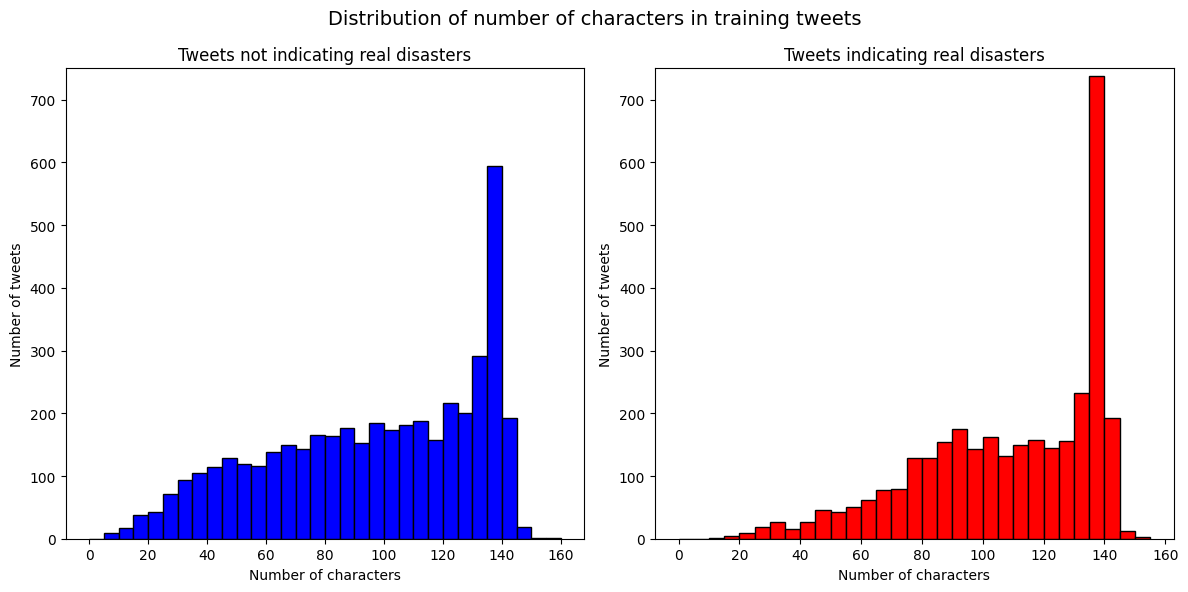

In [30]:
# Calculate character lengths for all tweets first
data_train['char_count'] = data_train['text'].str.len()

# Separate disaster and non-disaster tweets
data_train_0_char = data_train[data_train['target'] == 0]['char_count']
data_train_1_char = data_train[data_train['target'] == 1]['char_count']

def classwise_comparison_subplot(feature_0, feature_1, binwidth, title_0, title_1, ylimit, xlabel, ylabel, suptitle):
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the distributions
    axs[0].hist(feature_0, bins=range(0, int(feature_0.max()) + binwidth, binwidth), edgecolor='black', color='blue')
    axs[0].set_title(title_0)
    axs[0].set_ylim([0, ylimit])
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    axs[1].hist(feature_1, bins=range(0, int(feature_1.max()) + binwidth, binwidth), edgecolor='black', color='red')
    axs[1].set_title(title_1)
    axs[1].set_ylim([0, ylimit])
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)

    fig.suptitle(suptitle, fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot the distributions
classwise_comparison_subplot(feature_0=data_train_0_char,
                             feature_1=data_train_1_char,
                             binwidth=5,
                             title_0="Tweets not indicating real disasters",
                             title_1="Tweets indicating real disasters",
                             ylimit=750,
                             xlabel="Number of characters",
                             ylabel="Number of tweets",
                             suptitle="Distribution of number of characters in training tweets"
                             )


# Number of Words

We examine the distribution of number of words per tweet for both the class of non-disaster tweets and the class of disaster tweets.

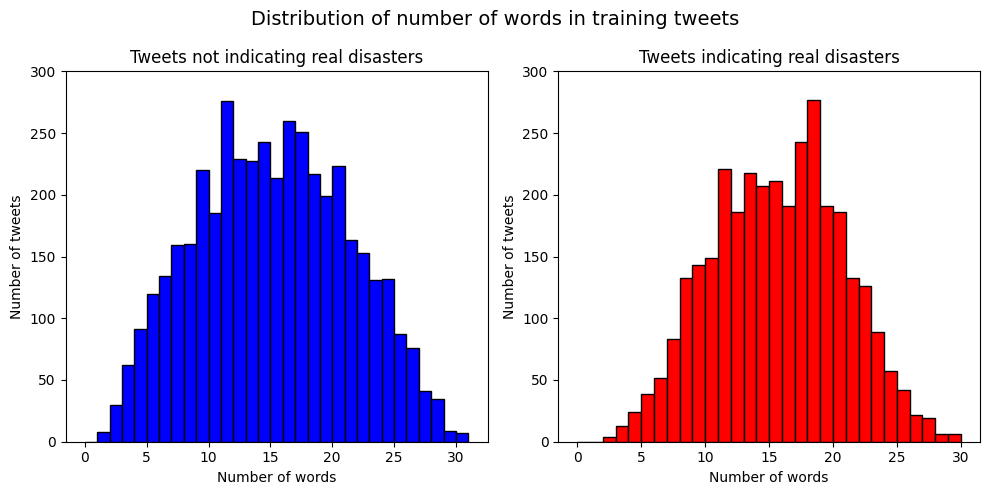

In [31]:
# Calculate word counts for all tweets
data_train['word_count'] = data_train['text'].str.split().map(lambda x: len(x))

# Separating disaster and non-disaster tweets
data_train_0_word = data_train[data_train['target'] == 0]['word_count']
data_train_1_word = data_train[data_train['target'] == 1]['word_count']

def classwise_comparison_subplot(feature_0, feature_1, binwidth, title_0, title_1, ylimit, xlabel, ylabel, suptitle):
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the distributions
    axs[0].hist(feature_0, bins=range(0, int(feature_0.max()) + binwidth, binwidth), edgecolor='black', color='blue')
    axs[0].set_title(title_0)
    axs[0].set_ylim([0, ylimit])
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    axs[1].hist(feature_1, bins=range(0, int(feature_1.max()) + binwidth, binwidth), edgecolor='black', color='red')
    axs[1].set_title(title_1)
    axs[1].set_ylim([0, ylimit])
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)

    fig.suptitle(suptitle, fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot the distributions
classwise_comparison_subplot(feature_0=data_train_0_word,
                             feature_1=data_train_1_word,
                             binwidth=1,
                             title_0="Tweets not indicating real disasters",
                             title_1="Tweets indicating real disasters",
                             ylimit=300,
                             xlabel="Number of words",
                             ylabel="Number of tweets",
                             suptitle="Distribution of number of words in training tweets"
                             )

# Length of Words


Next we analyze the distribution of average word-length in tweets for both the class of non-disaster tweets and the class of disaster tweets.




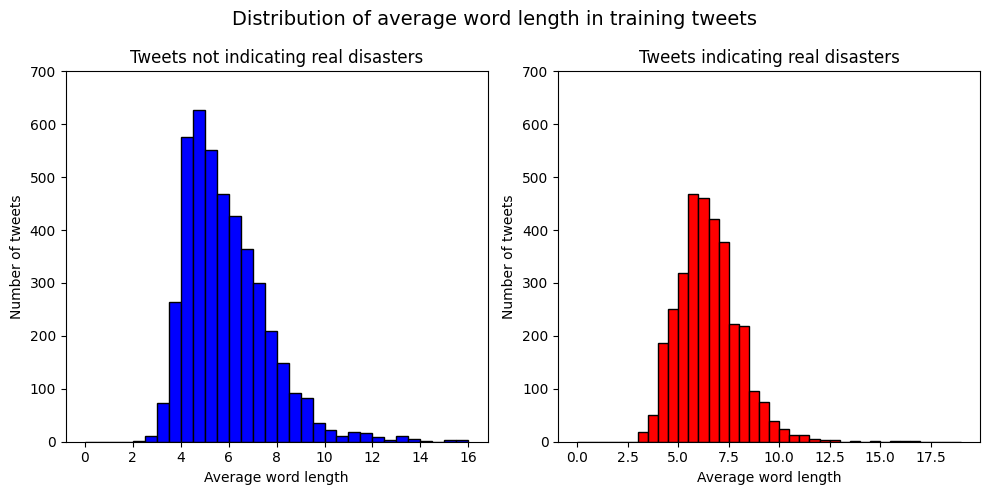

In [32]:
# Calculate the average word length for disaster and non-disaster tweets
data_train['avg_word_length'] = data_train['text'].str.split().apply(lambda x: np.mean([len(i) for i in x]))

# Separate disaster and non-disaster tweets based on average word length
data_train_0_avg = data_train[data_train['target'] == 0]['avg_word_length']
data_train_1_avg = data_train[data_train['target'] == 1]['avg_word_length']

def classwise_comparison_subplot(feature_0, feature_1, binwidth, title_0, title_1, ylimit, xlabel, ylabel, suptitle):
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Calculate bin edges for histograms to handle float binwidths
    bins_0 = np.arange(0, int(feature_0.max()) + binwidth, binwidth)
    bins_1 = np.arange(0, int(feature_1.max()) + binwidth, binwidth)

    # Plot the distributions using calculated bin edges
    axs[0].hist(feature_0, bins=bins_0, edgecolor='black', color='blue')
    axs[0].set_title(title_0)
    axs[0].set_ylim([0, ylimit])
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    axs[1].hist(feature_1, bins=bins_1, edgecolor='black', color='red')
    axs[1].set_title(title_1)
    axs[1].set_ylim([0, ylimit])
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)

    fig.suptitle(suptitle, fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot the distributions, using integer bandwidth
classwise_comparison_subplot(feature_0=data_train_0_avg,
                             feature_1=data_train_1_avg,
                             binwidth=0.5,
                             title_0="Tweets not indicating real disasters",
                             title_1="Tweets indicating real disasters",
                             ylimit=700,
                             xlabel="Average word length",
                             ylabel="Number of tweets",
                             suptitle="Distribution of average word length in training tweets"
                             )


# URLs

We examine the distribution of number of URLs per tweet for both the class of non-disaster tweets and the class of disaster tweets.

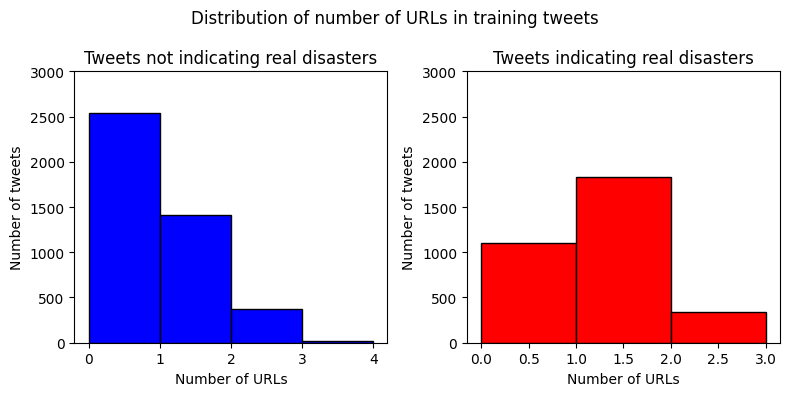

In [33]:
# Calculate the number of URLs in each tweet
data_train['url_count'] = data_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# Separate disaster and non-disaster tweets based on the number of URLs
url_train_0_count = data_train[data_train['target'] == 0]['url_count']
url_train_1_count = data_train[data_train['target'] == 1]['url_count']

# Function to plot histograms side by side
def classwise_comparison_subplot(feature_0, feature_1, binwidth, title_0, title_1, ylimit, xlabel, ylabel, suptitle):
    # Create subplots with smaller size
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # Adjust figsize for smaller plot

    # Plot the distributions
    axs[0].hist(feature_0, bins=range(0, int(feature_0.max()) + binwidth, binwidth), edgecolor='black', color='blue')
    axs[0].set_title(title_0)
    axs[0].set_ylim([0, ylimit])
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    axs[1].hist(feature_1, bins=range(0, int(feature_1.max()) + binwidth, binwidth), edgecolor='black', color='red')
    axs[1].set_title(title_1)
    axs[1].set_ylim([0, ylimit])
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)

    fig.suptitle(suptitle, fontsize=12)  # Adjust fontsize for the suptitle
    plt.tight_layout()
    plt.show()

# Plot the distributions
classwise_comparison_subplot(feature_0=url_train_0_count,
                             feature_1=url_train_1_count,
                             binwidth=1,
                             title_0="Tweets not indicating real disasters",
                             title_1="Tweets indicating real disasters",
                             ylimit=3000,
                             xlabel="Number of URLs",
                             ylabel="Number of tweets",
                             suptitle="Distribution of number of URLs in training tweets"
                             )


# Hashtags (#)
We examine the distribution of number of hashtags per tweet for both the class of non-disaster tweets and the class of disaster tweets.

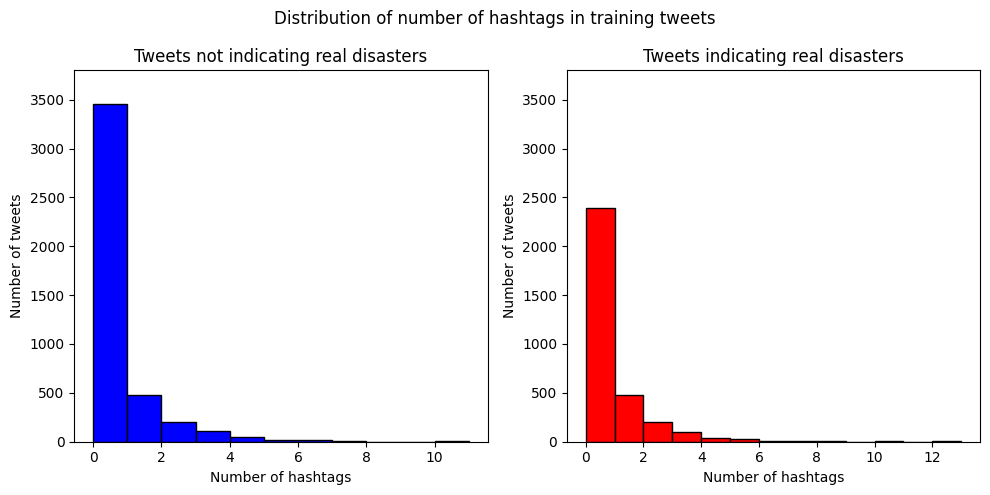

In [34]:
# Distribution of number of hashtags in tweets
hashtag_train_0_count = data_train_0["text"].apply(lambda x: len([c for c in str(x) if c == '#']))
hashtag_train_1_count = data_train_1["text"].apply(lambda x: len([c for c in str(x) if c == '#']))

# Function to plot histograms side by side with smaller size
def classwise_comparison_subplot(feature_0, feature_1, binwidth, title_0, title_1, ylimit, xlabel, ylabel, suptitle):
    # Create subplots with smaller size
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize for a smaller plot

    # Plot the distributions
    axs[0].hist(feature_0, bins=range(0, int(feature_0.max()) + binwidth, binwidth), edgecolor='black', color='blue')
    axs[0].set_title(title_0)
    axs[0].set_ylim([0, ylimit])
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    axs[1].hist(feature_1, bins=range(0, int(feature_1.max()) + binwidth, binwidth), edgecolor='black', color='red')
    axs[1].set_title(title_1)
    axs[1].set_ylim([0, ylimit])
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)

    fig.suptitle(suptitle, fontsize=12)  # Adjust fontsize for the suptitle
    plt.tight_layout()
    plt.show()

# Distribution of number of hashtags in tweets
classwise_comparison_subplot(feature_0=hashtag_train_0_count,
                             feature_1=hashtag_train_1_count,
                             binwidth=1,
                             title_0="Tweets not indicating real disasters",
                             title_1="Tweets indicating real disasters",
                             ylimit=3800,
                             xlabel="Number of hashtags",
                             ylabel="Number of tweets",
                             suptitle="Distribution of number of hashtags in training tweets"
                             )

# Mentions (@)
We examine the distribution of number of mentions per tweet for both the class of non-disaster tweets and the class of disaster tweets.

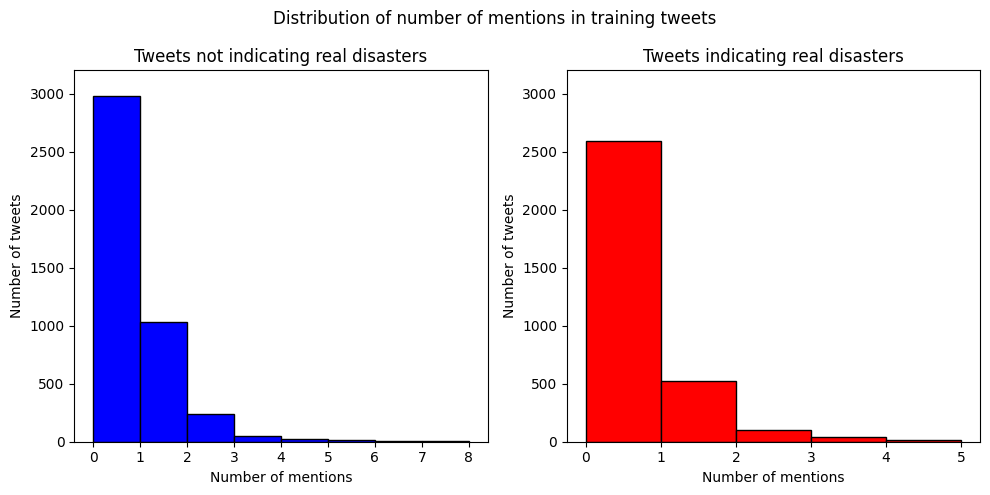

In [35]:
# Distribution of number of mentions in tweets
mention_train_0_count = data_train_0["text"].apply(lambda x: len([c for c in str(x) if c == '@']))
mention_train_1_count = data_train_1["text"].apply(lambda x: len([c for c in str(x) if c == '@']))

# Function to plot histograms side by side with smaller size
def classwise_comparison_subplot(feature_0, feature_1, binwidth, title_0, title_1, ylimit, xlabel, ylabel, suptitle):
    # Create subplots with smaller size
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize for a smaller plot

    # Plot the distributions
    axs[0].hist(feature_0, bins=range(0, int(feature_0.max()) + binwidth, binwidth), edgecolor='black', color='blue')
    axs[0].set_title(title_0)
    axs[0].set_ylim([0, ylimit])
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    axs[1].hist(feature_1, bins=range(0, int(feature_1.max()) + binwidth, binwidth), edgecolor='black', color='red')
    axs[1].set_title(title_1)
    axs[1].set_ylim([0, ylimit])
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)

    fig.suptitle(suptitle, fontsize=12)  # Adjust fontsize for the suptitle
    plt.tight_layout()
    plt.show()

# Plot the distributions
classwise_comparison_subplot(feature_0=mention_train_0_count,
                             feature_1=mention_train_1_count,
                             binwidth=1,
                             title_0="Tweets not indicating real disasters",
                             title_1="Tweets indicating real disasters",
                             ylimit=3200,
                             xlabel="Number of mentions",
                             ylabel="Number of tweets",
                             suptitle="Distribution of number of mentions in training tweets"
                             )

# Target and N-grams

# Target
Class distributions are 57% for 0 (Not Disaster) and 43% for 1 (Disaster). Classes are almost equally separated so they don't require any stratification by target in cross-validation.

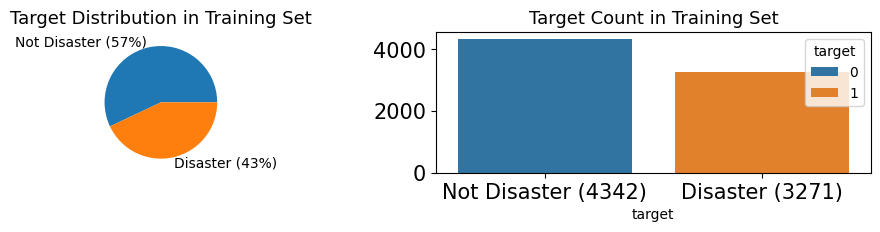

In [37]:
# Pie Chart and Count Plot for Target Distribution
fig, axes = plt.subplots(ncols=2, figsize=(10, 2), dpi=100)
plt.tight_layout()

data_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=data_train['target'], hue=data_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()


N-grams are used to represent sequences of words in a text, where n represents the number of words in the sequence.

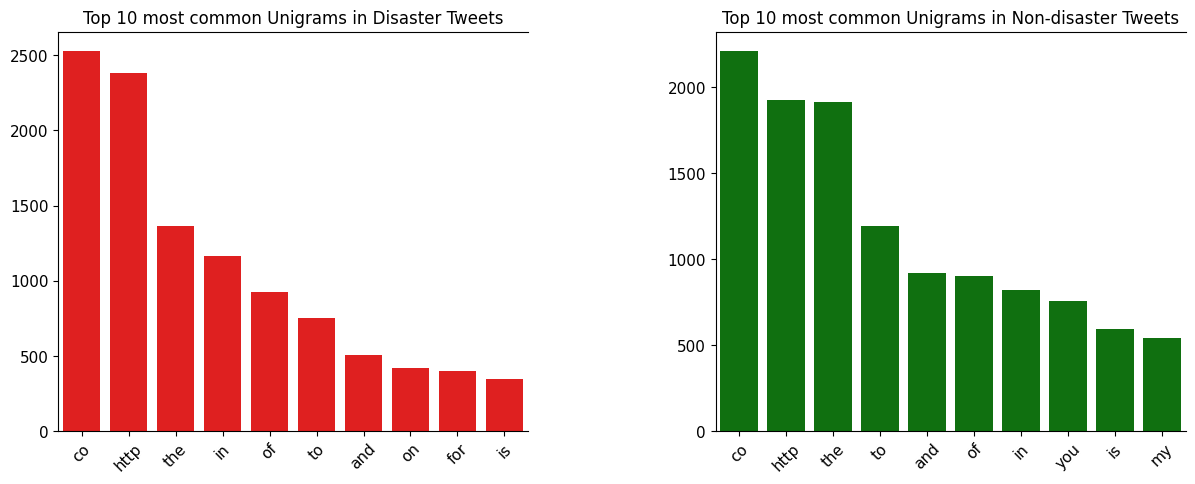

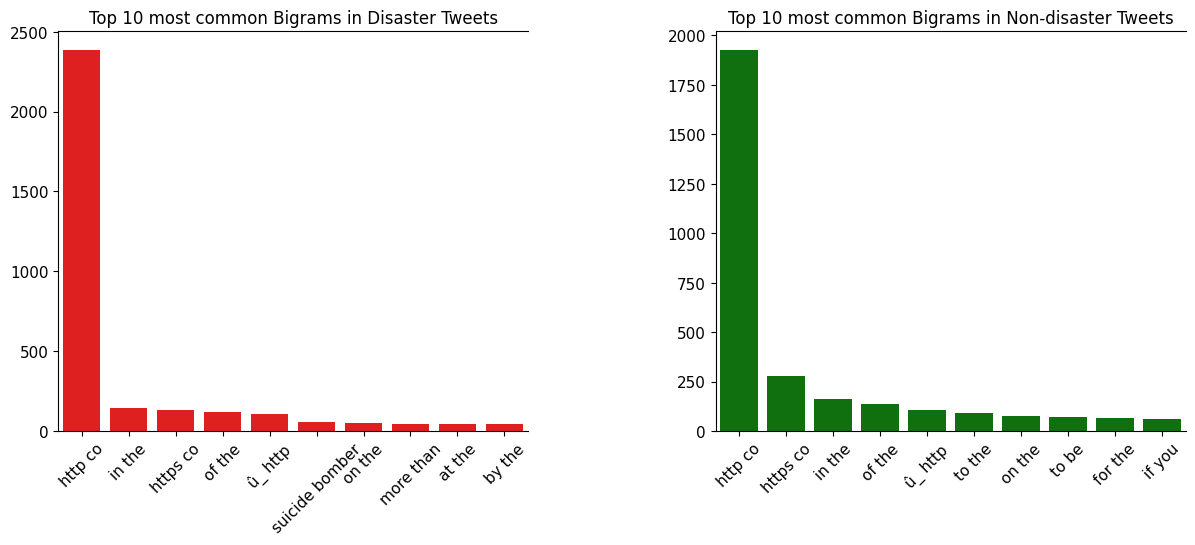

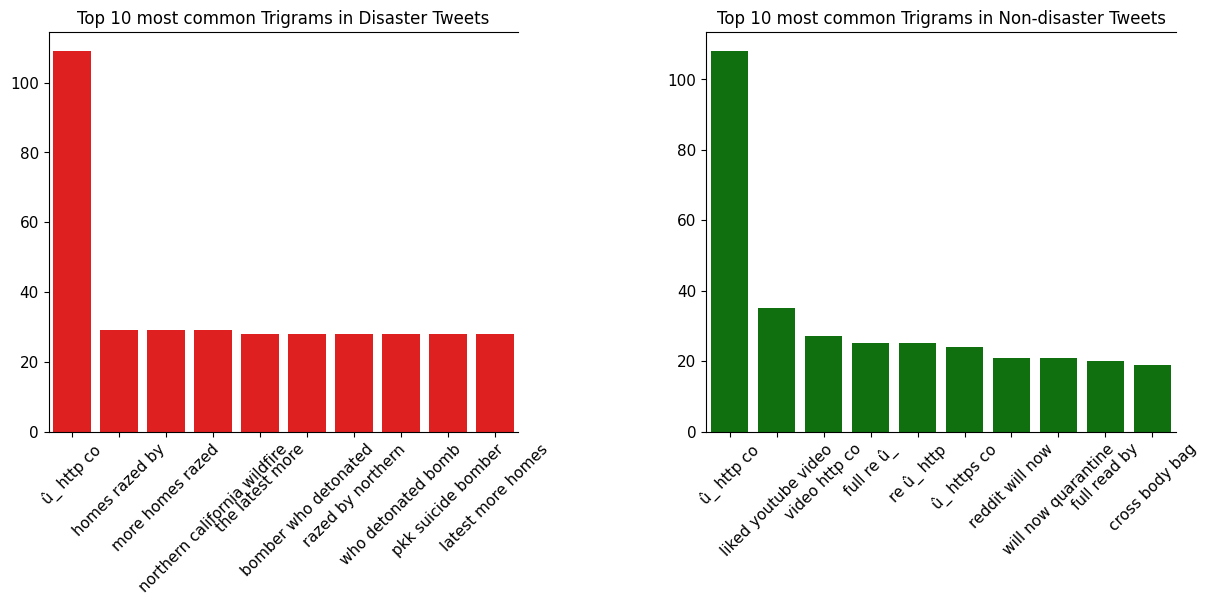

In [38]:
def visualize_ngrams(data_train, ngram_range=(1, 1), N=10, title_suffix=""):
    # Initialize the CountVectorizer with the specified n-gram range
    vectorizer = CountVectorizer(ngram_range=ngram_range)

    # Fit and transform the text data
    X_train = vectorizer.fit_transform(data_train['text'])

    # Create a DataFrame of the n-grams
    df_train_ngrams = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())

    # Calculate the frequency of n-grams in disaster and non-disaster tweets
    df_disaster_ngrams = df_train_ngrams[data_train['target'] == 1].sum().sort_values(ascending=False).reset_index()
    df_disaster_ngrams.columns = ['ngram', 0]

    df_nondisaster_ngrams = df_train_ngrams[data_train['target'] == 0].sum().sort_values(ascending=False).reset_index()
    df_nondisaster_ngrams.columns = ['ngram', 0]

    # Plot the top N n-grams for disaster and non-disaster tweets
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6), dpi=100)
    plt.tight_layout()

    sns.barplot(y=df_disaster_ngrams[0].values[:N], x=df_disaster_ngrams['ngram'].values[:N], ax=axes[0], color='red')
    sns.barplot(y=df_nondisaster_ngrams[0].values[:N], x=df_nondisaster_ngrams['ngram'].values[:N], ax=axes[1], color='green')

    for i in range(2):
        axes[i].spines['right'].set_visible(False)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', labelsize=11, rotation=45)
        axes[i].tick_params(axis='y', labelsize=11)

    ngram_type = 'Unigrams' if ngram_range == (1, 1) else 'Bigrams' if ngram_range == (2, 2) else 'Trigrams'
    axes[0].set_title(f'Top {N} most common {ngram_type} in Disaster Tweets{title_suffix}', fontsize=12)
    axes[1].set_title(f'Top {N} most common {ngram_type} in Non-disaster Tweets{title_suffix}', fontsize=12)

    plt.subplots_adjust(wspace=0.4, bottom=0.3)
    plt.show()

# Unigrams
visualize_ngrams(data_train, ngram_range=(1, 1), N=10)

# Bigrams
visualize_ngrams(data_train, ngram_range=(2, 2), N=10)

# Trigrams
visualize_ngrams(data_train, ngram_range=(3, 3), N=10)

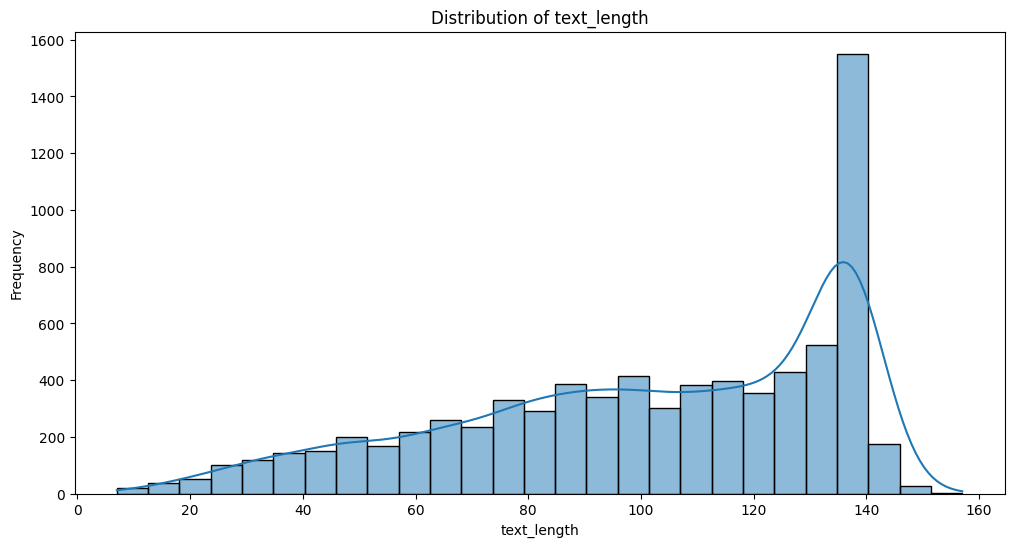

In [39]:
# Visualizing Numeric Features Distribution and Correlations
# Distribution of numeric features

data_train['text_length'] = data_train['text'].apply(len)

numeric_features = ['text_length']
for feature in numeric_features:
    plt.figure(figsize=(12, 6))
    sns.histplot(data_train[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

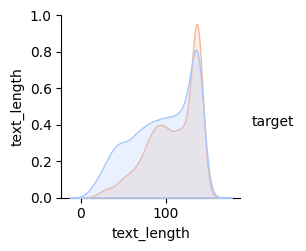

In [40]:
# Convert 'target' column to categorical type for better pairplot visualization
data_train['target'] = data_train['target'].astype('category')

# Pairplot of numeric features
sns.pairplot(data_train[numeric_features + ['target']], hue='target', palette='coolwarm')
plt.show()


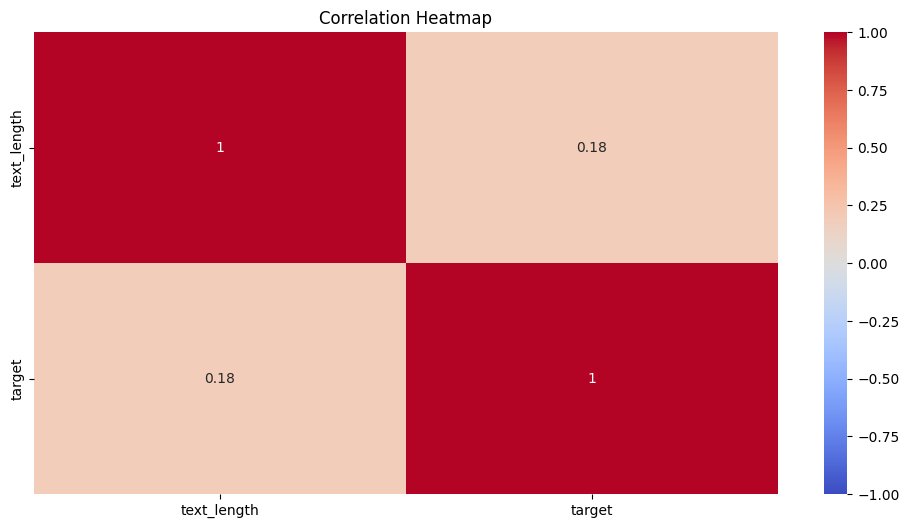

In [41]:
# Heatmap of correlation matrix

correlation_matrix = data_train[numeric_features + ['target']].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Data Preprocessing

In [42]:
# Handle missing values, text cleaning

# fill NaN values

data_train.fillna({'keyword': '', 'location': ''}, inplace=True)
data_test.fillna({'keyword': '', 'location': ''}, inplace=True)

# Function to preprocess text

def preprocess_text(text):

    #remove URLs
    text = re.sub(r'http\S+', '', text)

    #Remove mentions
    text = re.sub(r'@\w+', '', text)

    #Remove hashtags
    text = re.sub(r'#\w+', '', text)

    #Remove digits
    text = re.sub(r'\d+', '', text)

    #Remove extra spaces
    text = re.sub(r'\s+', '', text)

    # Remove punctuations
    text = ''.join(char for char in text if char.isalnum())

    # Convert to lowercase and strip
    text = text.strip().lower()
    return text

data_train['text'] = data_train['text'].apply(preprocess_text)
data_test['text'] = data_test['text'].apply(preprocess_text)

In [43]:
# Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardization on Training set'.center(120))
train_data_scaled = std.fit_transform(data_train[numeric_features])
train_data_scaled = pd.DataFrame(train_data_scaled, columns=numeric_features)
display(train_data_scaled.describe())

data_test['text_length'] = data_test['text'].apply(len)

print('\n', '\033[1mStandardization on Testing set'.center(120))
test_data_scaled = std.transform(data_test[['text_length']])
test_data_scaled = pd.DataFrame(test_data_scaled, columns=['text_length'])
display(test_data_scaled.describe())


                                          Standardization on Training set                                           


,text_length
count,7.613000e+03
mean,8.399954e-17
std,1.000066e+00
min,-2.783894e+00
25%,-6.820025e-01
50%,1.765163e-01
75%,9.462229e-01
max,1.656721e+00



                                            Standardization on Testing set                                           


,text_length
count,3263.000000
mean,-1.163416
std,0.765185
min,-2.872706
25%,-1.718146
50%,-1.185272
75%,-0.533982
max,0.531766


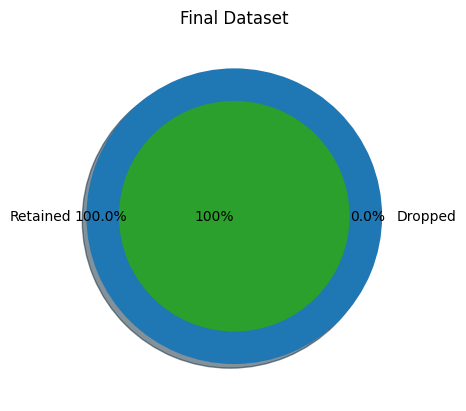


Inference: After the cleanup process, 0 samples were dropped, while retaining 0.0% of the data.


In [44]:
# Final Dataset size after performing Preprocessing

original_train_data = pd.read_csv('train.csv')
processed_train_data = data_train.copy()
processed_train_data.columns = [col.replace('-', '_') for col in processed_train_data.columns]

plt.title('Final Dataset')
plt.pie([processed_train_data.shape[0], original_train_data.shape[0] - processed_train_data.shape[0]],
        radius=1, labels=['Retained', 'Dropped'], counterclock=False, autopct='%1.1f%%', pctdistance=0.9,
        explode=[0, 0], shadow=True)
plt.pie([processed_train_data.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_train_data.shape[0] - processed_train_data.shape[0]} samples were dropped, \
while retaining {round(100 - (processed_train_data.shape[0] * 100 / original_train_data.shape[0]), 2)}% of the data.')

In [45]:
# Feature Extraction using LLM(BERT)

from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

data_train = pd.read_csv('train.csv')

#Functions to get BERT embeddings

def get_bert_embeddings(text):
  inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
  outputs = model(**inputs)
  last_hidden_states = outputs.last_hidden_state
  embeddings = torch.mean(last_hidden_states, 1).detach().numpy()
  return embeddings

# Extract embeddings for the training data

train_embeddings = []
for text in data_train['text']:
    emb = get_bert_embeddings(text)
    train_embeddings.append(emb)


train_embeddings = np.concatenate(train_embeddings, axis=0)

# Extract embeddings for the testing data

test_embeddings = []
for text in data_test['text']:
    emb = get_bert_embeddings(text)
    test_embeddings.append(emb)

test_embeddings = np.concatenate(test_embeddings, axis=0)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Validation Accuracy: 0.8142
Validation Precision: 0.8660
Validation Recall: 0.6672
Validation F1 Score: 0.7537
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       874
           1       0.87      0.67      0.75       649

    accuracy                           0.81      1523
   macro avg       0.83      0.80      0.80      1523
weighted avg       0.82      0.81      0.81      1523



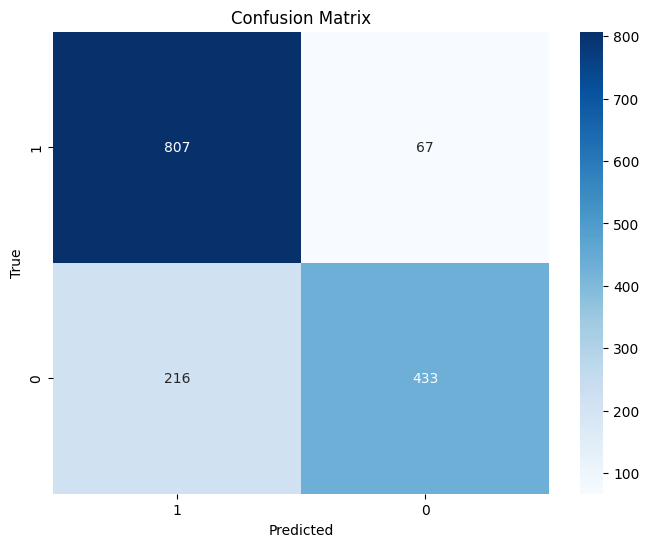

Submission file created successfully.


In [46]:
# Model Training

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score, f1_score, confusion_matrix

# Split the data into training and validation sets

X = train_embeddings
y = data_train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Model Evaluation

y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1 Score: {f1:.4f}')
print(classification_report(y_val, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_train['target'].unique(), yticklabels=data_train['target'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Make predictions on the test data
test_predictions = clf.predict(test_embeddings)

# Submission Preparation

submission_data['target'] = test_predictions
submission_data.to_csv('submission.csv', index=False)

print("Submission file created successfully.")